# Preliminaries

In [1]:
# Required standard libraries
import pandas as pd
import json
import urllib
import requests
import os
import re
import numpy as np
import bs4 as bs
import selenium
import html5lib
#import nltk
import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from matplotlib import pyplot as plt

# Extractors 
import extract

# Cleansers (cluster specific)
import cleanse

# Normalizer (generalised across all clusters)
from normalize import scaler

# Utils
from utils import utils

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Define filepaths

In [2]:
# Define the export path for all data exports
from pathlib import Path

# Current working directory
cwd = Path('.')

# Folder with data-in artifacts, quired to run this script
data_in = cwd / 'data_in'

# Folder containing data, which has been extracted manually, but entered by a machine
data_sources_raw_manual_machine = cwd / 'data_in' / 'data_raw_manually_extracted' / 'machine_entered'
data_sources_raw_manual_machine.mkdir(parents=True, exist_ok=True)

# Folder containing data, which has been extracted manually, and entered by a human
data_sources_raw_manual_human = cwd / 'data_in' / 'data_raw_manually_extracted' / 'human_entered'
data_sources_raw_manual_human.mkdir(parents=True, exist_ok=True)

# Folder containing manually extracted raw data, ready to be put in the loop
data_sources_staged_raw = cwd / 'data_out' / 'data_staged_raw'
data_sources_staged_raw.mkdir(parents=True, exist_ok=True)

# Folder to export raw data
data_sources_raw = cwd / 'data_out' / 'data_raw'
data_sources_raw.mkdir(parents=True, exist_ok=True)

# Folder to export cleansed data
data_sources_cleansed = cwd / 'data_out' / 'data_cleansed'
data_sources_cleansed.mkdir(parents=True, exist_ok=True)

# Folder to export normalized data
data_sources_normalized = cwd / 'data_out' / 'data_normalized'
data_sources_normalized.mkdir(parents=True, exist_ok=True)

# Folder to export validation results
validation_and_analysis = cwd / 'data_out' / 'data_validation'
validation_and_analysis.mkdir(parents=True, exist_ok=True)

## Load country list and mapping dictionary

In [3]:
# Load the list of countries which contains all different variations of country names 
country_full_list = pd.read_excel(
    data_in / 'all_countrynames_list.xlsx',
    keep_default_na = False).drop_duplicates()

# Create a version of the list with unique ISO2 and ISO3 codes
country_iso_list = country_full_list.drop_duplicates(subset = 'COUNTRY_ISO_2')

# Country CRBA list, this is the list of the countries that should be in the final CRBA indicator list
country_crba_list = pd.read_excel(
    data_in / 'crba_country_list.xlsx',
    header = None,
    usecols = [0, 1], 
    names = ['COUNTRY_ISO_3', 'COUNTRY_NAME']).merge(
        right = country_iso_list[['COUNTRY_ISO_2', 'COUNTRY_ISO_3']],
        how = 'left',
        on='COUNTRY_ISO_3',
        validate = 'one_to_one')

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'column_mapping.py') as file:
    exec(file.read())

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'value_mapping.py') as file:
    exec(file.read())

## Read data dictionary

In [33]:
# sources sheet
crba_data_dictionary_source = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Source",
    keep_default_na = False
)
    # Delete sources that are deprecated
crba_data_dictionary_source = crba_data_dictionary_source[crba_data_dictionary_source.STATUS != 'Deleted']

# snapshot sheet
crba_data_dictionary_snapshot = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Snapshot",
    keep_default_na = False
)

# Delete snapshots which aren't used in 2020
crba_data_dictionary_snapshot = crba_data_dictionary_snapshot[crba_data_dictionary_snapshot.YEAR_USED == 2020]

# indicator sheet
crba_data_dictionary_indicator = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Indicator",
    keep_default_na = False,
)

    # Delete indicators that are deprecated
crba_data_dictionary_indicator = crba_data_dictionary_indicator[crba_data_dictionary_indicator.STATUS != 'Deleted']

    # Pandas also reads rows with no content (empty strings)
crba_data_dictionary_indicator = crba_data_dictionary_indicator.loc[crba_data_dictionary_indicator.INDICATOR_NAME != '', :]


# Input lists
crba_data_dictionary_input_list = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Input_Lists",
    keep_default_na = False
)

# Add 2-digit shortcodes of index, issue and category to indicators sheet
crba_data_dictionary_indicator = crba_data_dictionary_indicator.merge(
    right=crba_data_dictionary_input_list[['INDEX', 'INDEX_CODE']],
    left_on='INDEX',
    right_on='INDEX'
).merge(
    right=crba_data_dictionary_input_list[['ISSUE', 'ISSUE_CODE']],
    left_on='ISSUE',
    right_on='ISSUE'
).merge(
    right=crba_data_dictionary_input_list[['CATEGORY', 'CATEGORY_CODE']],
    left_on='CATEGORY',
    right_on='CATEGORY'
)

# Create indicator code prefix (INDEX-ISSUE_CAEGORY CODE)
crba_data_dictionary_indicator = crba_data_dictionary_indicator.assign(
    INDICATOR_CODE_PREFIX = crba_data_dictionary_indicator.INDEX_CODE +
    "_" +
    crba_data_dictionary_indicator.ISSUE_CODE+
    "_"+
    crba_data_dictionary_indicator.CATEGORY_CODE+
    "_")

# Create indicator code
crba_data_dictionary_indicator = crba_data_dictionary_indicator.assign(
    INDICATOR_CODE = crba_data_dictionary_indicator.INDICATOR_CODE_PREFIX + crba_data_dictionary_indicator.INDICATOR_NAME.apply(
    lambda x: utils.create_ind_code(x)
))

# Check if there are indicators which have been assigned the same indicator code: 
duplicate_codes = crba_data_dictionary_indicator[crba_data_dictionary_indicator.duplicated(subset = 'INDICATOR_CODE', keep = False)][['INDICATOR_CODE', 'INDICATOR_ID']]

if len(duplicate_codes) != 0:
    raise Exception(f"WARNING: Theese are indicator names that have been assigned with the same indicator code {duplicate_codes} \n Please change the names to avoid duplicates")
else:
    print("No duplicate indicator codes present. You can proceed.")

No duplicate indicator codes present. You can proceed.


In [ ]:
import importlib, inspect

extractors = { 
    cls.type: cls for name, cls in inspect.getmembers(
        importlib.import_module("extract"), 
        inspect.isclass
    ) if hasattr(cls, 'type')
}

# Staging (pre-processing) to create exceptional indicators´ raw data 

#

In [22]:
# Pre-processing of exceptional indicators, which require extra transformation
# Important: File requires having filepaths from above defined and pandas already imported
#with open(data_in / 'staging_create_raw_data_machine_entered.py') as file:
#    exec(file.read())

with open(data_in / 'staging_create_raw_data_human_entered.py') as file:
    exec(file.read())

Pre-processing file S_12
Pre-processing file S_69
Pre-processing file S_70
Pre-processing file S_96
Pre-processing file S_87
Pre-processing file S_106
Pre-processing file S_109
Pre-processing file S_116
Pre-processing file S_117
Pre-processing file S_118
Pre-processing file S_119
Pre-processing file S_121
Pre-processing file S_122
Pre-processing file S_123
Pre-processing file S_139
Pre-processing file S_140
Pre-processing file S_147
Pre-processing file S_148
Pre-processing file S_149
Pre-processing file S_150
Pre-processing file S_151
Pre-processing file S_152
Pre-processing file S_165
Pre-processing file S_172
Pre-processing file S_175
Pre-processing file S_176
Pre-processing file S_179
Pre-processing file S_213
Pre-processing file S_228
Pre-processing file S_233
Pre-processing file S_234
Pre-processing file S_235
Pre-processing file S_236
Pre-processing file S_237
Pre-processing file S_238
Pre-processing file S_46
Pre-processing file S_54
Pre-processing file S_128
Pre-processing file

# Extract - Transform - Load Loops
## API sources
### CSV API sources

In [6]:
# CSV sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (ILO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNESCO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (WHO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNICEF)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (NRGI)")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# # # # # # # # # # # #
# Delete again (only for temporary debugging 12.11.20)
# # # # # # # # # # # # 
#api_sources = api_sources[(api_sources["SOURCE_ID"] == 'S-155') | 
# (api_sources["SOURCE_ID"] == 'S-156')]
#api_sources = api_sources[(api_sources["SOURCE_ID"] == 'S-97')]

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Extraction section
    # try:
        # Extract data
    # print(row["ENDPOINT_URL"]+"continue here")
    dataframe = extract.CSVExtractor.extract(url = row["ENDPOINT_URL"])
    
    # Save raw data
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )
    
    # except:
    print("There was a problem with extraction of source {} \n".format(row["SOURCE_ID"]))
    
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    # Specific to data from API (NRGI) --> Only two sources
    if row["SOURCE_TYPE"] == "API (NRGI)":
        dataframe['RAW_OBS_VALUE'] = dataframe['RAW_OBS_VALUE'].apply(
            lambda x: np.nan if x == '.' else x
        )

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )

    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )
    
    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

Dataframe cleansed was not defined yet. Now defining it.
Dataframe normalized was not defined yet. Now defining it.

 - - - - - 
 Extracting source S-50 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column DATAFLOW has 1 unique values.
The column COLLECTION has 1 unique values.
The column REF_AREA has 39 unique values.
The column FREQ has 1 unique values.
The column MEASURE has 1 unique values.
The column OCU has 13 unique values.
The column TIME_PERIOD has 10 unique values.
The column OBS_VALUE has 895 unique values.
The column OBS_STATUS has 1 unique values.
The column UNIT_MEASURE_TYPE has 1 unique values.
The column UNIT_MEASURE has 1 unique values.
The column UNIT_MULT has 1 unique values.
The column SOURCE_NOTE has 118 unique values.
The column INDICATOR_NOTE has 76 unique values.
The column CLASSIFICATION_NOTE has 1 unique values.
The column CURRENCY_NOTE has 34 unique values.
The column DECIMALS has 1 unique values.

### JSON API sources

In [7]:
# JSON sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (SDG)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (WB)")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# # # # # # # # # # # #
# Delete again (only for temporary debugging 12.11.20)
# # # # # # # # # # # # 
api_sources = api_sources[
    (api_sources["SOURCE_ID"] != 'S-212')] #& 
    #(api_sources["SOURCE_ID"] == 'S-161')] #|
"""    (api_sources["SOURCE_ID"] == 'S-224') |
    (api_sources["SOURCE_ID"] == 'S-225') |
    (api_sources["SOURCE_ID"] == 'S-226')
]"""

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    #try:
    # Extract data 
    dataframe = extract.JSONExtractor.extract(url = row["ENDPOINT_URL"])
    
    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")
    # except:
        #print("There was an issue with source {}".format(row["SOURCE_ID"]))
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing in 
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().convert_nan_strings_into_nan(
        dataframe = dataframe
    )

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )

    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )

    # print(dataframe)

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"],
        na_encodings = row["NA_ENCODING"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-23 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column goal has 1 unique values.
The column target has 1 unique values.
The column indicator has 1 unique values.
The column series has 1 unique values.
The column seriesDescription has 1 unique values.
The column seriesCount has 1 unique values.
The column geoAreaCode has 86 unique values.
The column geoAreaName has 86 unique values.
The column timePeriodStart has 20 unique values.
The column value has 3190 unique values.
The column valueType has 1 unique values.
The column time_detail has 1 unique values.
The column timeCoverage has 1 unique values.
The column upperBound has 1 unique values.
The column lowerBound has 1 unique values.
The column basePeriod has 1 unique values.
The column source has 51 unique values.
The column geoInfoUrl has 1 unique values.
The column footnotes has 17 unique values.
The column attributes.Nature has 2 unique

## HTML Sources
### UN Treaty Sources

In [8]:
# UN Treaty HTML sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_BODY"] == "UN Treaties")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    dataframe = extract.HTMLExtractor().extract(url = row["ADDRESS"])
    
    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")

    # Cleansing
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    # UN Treaty data specific: Sometimes, countries have footnotes (numbers). These must be purged for the rest of the code to work properly
    dataframe['COUNTRY_NAME'] = dataframe['COUNTRY_NAME'].apply(lambda x: re.sub('\s\d+.*', '', x)) # delete everything after number (and the leading whitespace)

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body = row["SOURCE_BODY"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-3 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column Participant has 185 unique values.
The column Signature has 59 unique values.
The column Ratification, Accession(a), Succession(d) has 173 unique values.

 - - - - - 
 Cleansing source S-3 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-4 

The following colum

### ILO NORMLEX sources

In [ ]:
# ILO Normlex sources
ilo_normlex_sources = crba_data_dictionary_source[crba_data_dictionary_source.SOURCE_BODY == 'ILO NORMLEX'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Sources S-168, S-169 and S-170 require a different ETL (i.e. the same ETL as UN Treaties) --> Exclude them from this loop 
# ilo_normlex_sources = ilo_normlex_sources[
# (ilo_normlex_sources["SOURCE_ID"] != 'S-1')]# & 
#(manually_extracted_sources["SOURCE_ID"] != 'S-169') &
#(manually_extracted_sources["SOURCE_ID"] != 'S-170') #&
#(manually_extracted_sources["SOURCE_ID"] == 'S-21')] 

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Define parameters required for Selenium to work (can't use Posix path with selenium)
# Specify location of chromedriver
cwd = os.getcwd()
driver_location = cwd + '\\chromedriver.exe'

# Add option to make it headless (so that it doesn't open an actual chrome window)
options = Options()
options.headless = True
driver = webdriver.Chrome(driver_location, chrome_options=options)
    
# Loop to extract data from API sources
for index, row in ilo_normlex_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))

    # request
    print(row["ADDRESS"])
    response = driver.get(row["ADDRESS"])

    # Soupify the actual html content from response
    soup = bs.BeautifulSoup(driver.page_source)

    # Extract the target table as attribute
    target_table = str(
        soup.find_all("table", {"cellspacing": "0", "class": "horizontalLine"})
    )

    # Create dataframe with the data
    raw_data = pd.read_html(io=target_table, header=0)[
        0
    ]# return is a list of DFs, specify [0] to get actual DF

    # Save raw data (as actual raw, rather than staged raw data)
    raw_data.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )

    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=raw_data,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().decompose_country_footnote_ilo_normlex(
        dataframe = dataframe,
        country_name_list = country_full_list["COUNTRY_NAME"]
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["SOURCE_ID"], # TO DO: exchange this with row["INDICATOR_CODE"] in selenium  
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body='ILO NORMLEX'
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Create log info
    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        log_info=True
        )

    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

## Other sources
### WPA sources

In [9]:
# 1. Create a flat file of all WPA sources
# Read and join all world policy analysis centre data
wpa_child_labor = pd.read_excel(
    io = data_sources_raw_manual_machine / 'S_8, S_9' / 'WORLD_child_labor.xls'
)

wpa_childhood = pd.read_excel(
    io = data_sources_raw_manual_machine / 'S_10, S_13, S_36, S_45, S_49' / 'WORLD_Dataset_Childhood_4.16.15.xls'
)

wpa_adult_labor = pd.read_excel(
    io = data_sources_raw_manual_machine / 'S_40, S_41, S_63, S_64, S_65, S_66, S_67, S_68' / 'WORLD_Dataset_Adult_Labor_9.17.2018.xls'
)

wpa_discrimination = pd.read_excel(
    io = data_sources_raw_manual_machine / 'S_42, S_43, S_44' / 'WORLD_discrimination_at_work.xls'
)

# Create list to write a loop
wpa_combined_list=[
    wpa_childhood,
    wpa_adult_labor,
    wpa_discrimination
 ]

# Loop to join all dataframes
wpa_combined = wpa_child_labor

for df in wpa_combined_list:
    wpa_combined = wpa_combined.merge(
        right=df,
        on=['iso2', 'iso3']
    )

# 2. Loop
wpa_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_BODY"] == "World Policy Analysis Centre")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in wpa_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    #try:
    # Extract data 
    # Log that we are entering cleasning
    print("\n Extracting data and store it as raw data")

    dataframe = wpa_combined[['iso3', row['WPA_OBS_RAW_COL']]] 
    dataframe['TIME_PERIOD'] = row['WPA_YEAR_COL'] 

    #print(dataframe.head(30))

    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")
    #except:
    print("There was an issue with source {}".format(row["SOURCE_ID"]))
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing 
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    #print(dataframe['RAW_OBS_VALUE'].unique())

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    
    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )
    

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")

    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )

    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-8 


 Extracting data and store it as raw data
There was an issue with source S-8

 - - - - - 
 Cleansing source S-8 


 - - - - - 
 Cleansing source S-8 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_categorical_variables'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.000000
mean     2019.010256
std         0.101013
min      2019.000000
25%      2019.000000
50%      2019.000000
75%      2019.000000
max      2020.000000
Name: TIME_PERIOD, dtype: float64

 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-9 


 Extracting data and store it as raw data
There was an issue with source S-9

 - - - - - 
 Cleansing source S-9 


 - - - - - 
 

### Manually extracted data (both human and machine-generated data) + data which required pre-processing
#### Normal ETL-pipeline


 - - - - - 
 Extracting source S-11 


 - - - - - 
 Cleansing source S-11 


 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'map_values'...
Values of column: DIM_SEX couldn't be mapped. If column DIM_SEX is present, there is an error with the code. 
Values of column: DIM_EDU_LEVEL couldn't be mapped. If column DIM_EDU_LEVEL is present, there is an error with the code. 
Values of column: DIM_AGE couldn't be mapped. If column DIM_AGE is present, there is an error with the code. 
Values of column: DIM_AGE_GROUP couldn't be mapped. If column DIM_AGE_GROUP is present, there is an error with the code. 
Values of column: DIM_MANAGEMENT_LEVEL couldn't be mapped. If column DIM_MANAGEMENT_LEVEL is present, there is an error with the code. 
Values of column: DIM_AREA_TYPE couldn

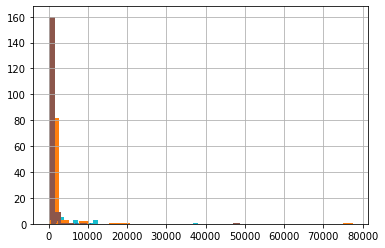

In [34]:
# Manually extracted source, which were pre-processed
manually_extracted_sources = crba_data_dictionary_source[crba_data_dictionary_source.REQUIRE_STAGING == 'Yes'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Sources S-168, S-169 and S-170 require a different ETL (i.e. the same ETL as UN Treaties) --> Exclude them from this loop 
manually_extracted_sources = manually_extracted_sources[
(manually_extracted_sources["SOURCE_ID"] != 'S-168') & 
(manually_extracted_sources["SOURCE_ID"] != 'S-169') &
(manually_extracted_sources["SOURCE_ID"] != 'S-170') #&
#(manually_extracted_sources["SOURCE_ID"] == 'S-189')
] 

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in manually_extracted_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    dataframe = pd.read_csv(
        data_sources_staged_raw
        / (row["SOURCE_ID"] + "_staged_raw.csv"),
        sep = ';'
    )

    # Save raw data (as actual raw, rather than staged raw data)
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    """# Cleansing
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )"""

    # print(dataframe)
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )
    
    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    print(dataframe.RAW_OBS_VALUE.describe())

    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # print(dataframe_cleansed)

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        log_info = True
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

#### Treaty data pipeline

This pipeline is identical to HTML-Sources: UN Treaties data. It concerns sources S-168, S-169 and S-170

In [11]:
# Manually extracted source, which were pre-processed
manually_extracted_sources = crba_data_dictionary_source[crba_data_dictionary_source.REQUIRE_STAGING == 'Yes'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Sources S-168, S-169 and S-170 require a different ETL (i.e. the same ETL as UN Treaties) --> Exclude them from this loop 
manually_extracted_sources = manually_extracted_sources[(manually_extracted_sources["SOURCE_ID"] == 'S-168') | 
(manually_extracted_sources["SOURCE_ID"] == 'S-169') |
(manually_extracted_sources["SOURCE_ID"] == 'S-170') 
] 

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in manually_extracted_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    dataframe = pd.read_csv(
        data_sources_staged_raw
        / (row["SOURCE_ID"] + "_staged_raw.csv"),
        sep = ';'
    )

    # Save raw data (as actual raw, rather than staged raw data)
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )    
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    # UN Treaty data specific: Sometimes, countries have footnotes (numbers). These must be purged for the rest of the code to work properly
    #dataframe['COUNTRY_NAME'] = dataframe['COUNTRY_NAME'].apply(lambda x: re.sub('\s\d+.*', '', x)) # delete everything after number (and the leading whitespace)

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body = row["SOURCE_BODY"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        log_info=True
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-168 


 - - - - - 
 Cleansing source S-168 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-169 


 - - - - - 
 Cleansing source S-169 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information 

## Export concatented dataframe

In [36]:
# define emty dataframe
combined_normalized_csv = pd.DataFrame()

# Iterate through all files
for file in data_sources_normalized.iterdir():
    try:
        print(file)
        dataframe = pd.read_csv(
                file,
                sep = ';'
            )

        # print(dataframe)

        dataframe['INTERNAL_SOURCE_ID'] = file
        
        combined_normalized_csv = combined_normalized_csv.append(
            other = dataframe
        )
    except:
        print('didnt read file')
        print(file)

# Idenify all dimension columns in combined dataframe
available_dim_cols = []
for col in combined_normalized_csv.columns:
    dim_col = re.findall("DIM_.+", col)
    # print(dim_col)
    if len(dim_col) == 1:
        available_dim_cols += dim_col

# Fill _T for all NA values of dimension columns
combined_normalized_csv[available_dim_cols] = combined_normalized_csv[
    available_dim_cols
].fillna(value="_T")

# Double check if there are duplicate countries
print("This is the number of duplicate rows:")
print(sum(combined_normalized_csv.duplicated()))
print(combined_normalized_csv.loc[combined_normalized_csv.duplicated(), ['COUNTRY_ISO_3','INDICATOR_NAME', 'INDICATOR_CODE']])
#combined_normalized_csv = combined_normalized_csv.drop_duplicates() # uncomment if want to delete duplicates (but check where they come from first)

# Export combined cleansed dataframe as a sample
combined_normalized_csv.to_csv(
    path_or_buf = cwd / 'data_out' / 'combined_normalized.csv',
    sep = ";"
)

data_out/data_normalized/S-100_normalized.csv
data_out/data_normalized/S-101_normalized.csv
data_out/data_normalized/S-103_normalized.csv
data_out/data_normalized/S-104_normalized.csv
data_out/data_normalized/S-105_normalized.csv
data_out/data_normalized/S-106_normalized.csv
data_out/data_normalized/S-109_normalized.csv
data_out/data_normalized/S-10_normalized.csv
data_out/data_normalized/S-113_normalized.csv
data_out/data_normalized/S-115_normalized.csv
data_out/data_normalized/S-116_normalized.csv
data_out/data_normalized/S-117_normalized.csv
data_out/data_normalized/S-118_normalized.csv
data_out/data_normalized/S-119_normalized.csv
data_out/data_normalized/S-11_normalized.csv
data_out/data_normalized/S-120_normalized.csv
data_out/data_normalized/S-121_normalized.csv
data_out/data_normalized/S-122_normalized.csv
data_out/data_normalized/S-123_normalized.csv
data_out/data_normalized/S-124_normalized.csv
data_out/data_normalized/S-125_normalized.csv
data_out/data_normalized/S-126_norma

# Validation and exploratory data analysis

### Age of observations
#### Entire dataset

The number  of observations older than 10 years is (NB: this is concerning all dimension subgroups): 
 
  INDICATOR_NAME
Average earnings                                    578
Ban on alcohol advertising on national TV             3
Child malnutrition under 6 months                   540
Coverage of labour market programmes                 34
Damaged livelihoods associated with disasters\t      21
Deaths associated with disasters\t                    6
Disruption to education services\t                    6
Disruption to health services\t                       4
Education spending\t                                 22
Exclusive breastfeeding\t                            33
Frequency of bullying                                51
New displacements of people by natural disasters      1
Poorest covered by labour market programmes          34
Poorest covered by social insurance                  64
Poverty rates                                        16
Prevalence of hazardous work by adolesc

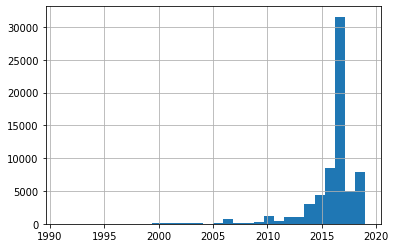

In [37]:
# Visualize distribution of age of observations
combined_normalized_csv.loc[(combined_normalized_csv['TIME_PERIOD']>1990) & (combined_normalized_csv['TIME_PERIOD']<2020), 'TIME_PERIOD'].hist(bins = 30)

# save fgure
plt.savefig(validation_and_analysis / 'observation_year_all_observations.png')

# Print number of observations older than 2010
old_data = combined_normalized_csv[combined_normalized_csv['TIME_PERIOD']<2010] 
# Number of observations older than 2010
old_data_grouped = old_data.groupby('INDICATOR_NAME').count()

print(f"The number  of observations older than 10 years is (NB: this is concerning all dimension subgroups): \n \n  {old_data_grouped.COUNTRY_ISO_3} \n ")

# # # # Calculate the % of obs older 2010 for each indicator
# Retrieve total number of observations
combined_normalized_csv_grouped = combined_normalized_csv.groupby('INDICATOR_NAME').count()

# Compare the number of rows older 2010 and total number of rows per indicators
old_data_analysis = old_data_grouped[['COUNTRY_ISO_3']].merge(
    right = combined_normalized_csv_grouped[['COUNTRY_ISO_3']],
    on = 'INDICATOR_NAME'
)

# Add column indicating % of obs older
old_data_analysis['OBS_PERCENT_OLDER_2010'] = round((old_data_analysis["COUNTRY_ISO_3_x"] / old_data_analysis["COUNTRY_ISO_3_y"]) * 100, 1) 

print(f"The percentage of observations older than 10 years is: \n \n  {old_data_analysis.OBS_PERCENT_OLDER_2010} \n ")

#### Subset dataset

This is the summary statistics about the age of observation of all _relevant_ rows. This means that:

* we are disregarding dimension-subgroups which were not used for normalization
* we disregard countries for which data was N/A for a given indicator (because these countries have TIME_PERIOD == 2020)

In other words, we are looking at each indicator at the subset of 195 countries for which data was available in the relevant dimension-subgroup.

The number  of observations older than 10 years is (NB: this is concerning only the relevant dimension-subgroup of the indicator): 
 
  Series([], Name: COUNTRY_ISO_3, dtype: int64) 
 
The percentage of observations older than 10 years is: 
 
  Series([], Name: OBS_PERCENT_OLDER_2010, dtype: float64) 
 


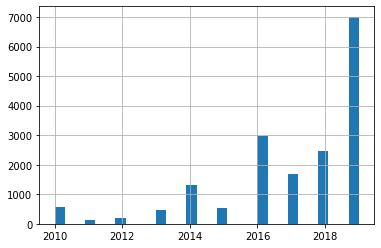

In [38]:
# Create a subset of the data we are actually interested in, i.e. 195 countries for each indicator --> filter out irrelevant dimension-subgroups
relevant_combined_normalized_csv = combined_normalized_csv.loc[
    combined_normalized_csv.SCALED_OBS_VALUE.notna()
]

# Visualize distribution of age of observations
relevant_combined_normalized_csv.loc[(relevant_combined_normalized_csv['TIME_PERIOD']>1990) & (relevant_combined_normalized_csv['TIME_PERIOD']<2020), 'TIME_PERIOD'].hist(bins = 30)
    
# save fgure
plt.savefig(validation_and_analysis / 'observation_year_relevant_dimension_subgroup.png')

# Print number of observations older than 2010
relevant_old_data = relevant_combined_normalized_csv[relevant_combined_normalized_csv['TIME_PERIOD']<2010] 

# Number of observations older than 2010
relevant_old_data_grouped = relevant_old_data.groupby('INDICATOR_NAME').count()

print(f"The number  of observations older than 10 years is (NB: this is concerning only the relevant dimension-subgroup of the indicator): \n \n  {relevant_old_data_grouped.COUNTRY_ISO_3} \n ")

# # # # Calculate the % of obs older 2010 for each indicator
# Retrieve total number of observations
relevant_combined_normalized_csv_grouped = relevant_combined_normalized_csv.groupby('INDICATOR_NAME').count()

# Compare the number of rows older 2010 and total number of rows per indicators
relevant_old_data_analysis = relevant_old_data_grouped[['COUNTRY_ISO_3']].merge(
    right = relevant_combined_normalized_csv_grouped[['COUNTRY_ISO_3']],
    on = 'INDICATOR_NAME'
)

# Add column indicating % of obs older
relevant_old_data_analysis['OBS_PERCENT_OLDER_2010'] = round((relevant_old_data_analysis["COUNTRY_ISO_3_x"] / relevant_old_data_analysis["COUNTRY_ISO_3_y"]) * 100, 1) 

print(f"The percentage of observations older than 10 years is: \n \n  {relevant_old_data_analysis.OBS_PERCENT_OLDER_2010} \n ")

# Save dataframe
relevant_old_data_analysis.to_csv(validation_and_analysis / 'percentage_observations_older_2010_per_indicator.csv',
    sep = ';')

### Number of NaN-countries per indicator

In [39]:
# # # # # # Calculate number of countries with NaN per indicator
relevant_observations = combined_normalized_csv.loc[
    (combined_normalized_csv.OBS_STATUS == 'O') |
    (combined_normalized_csv.SCALED_OBS_VALUE.notna()), 
]

# Calculate the total number of observations per indicator
total_obs_per_ind = relevant_observations.groupby('INDICATOR_CODE', as_index = False).count()[['INDICATOR_CODE','Unnamed: 0']]

# Calculate the number of NA observations
na_obs_per_ind = relevant_observations.loc[relevant_observations.OBS_STATUS == 'O', ].groupby('INDICATOR_CODE', as_index = False).count()[['INDICATOR_CODE','Unnamed: 0']]
 
joined = total_obs_per_ind.merge(
    right=na_obs_per_ind,
    on='INDICATOR_CODE',
    how='outer'
)

# Calculate percentage
joined['PERCENTAGE_OF_COUNTRIES_MISSING'] = joined['Unnamed: 0_y'] / joined['Unnamed: 0_x'] * 100

# Replace np.nan with 0
joined.loc[joined['PERCENTAGE_OF_COUNTRIES_MISSING'].isna() , 'PERCENTAGE_OF_COUNTRIES_MISSING'] = 0

# Get indincator name and source
joined = joined.merge(
    right=relevant_observations.groupby(
        'INDICATOR_CODE', as_index=False).first(
        )[['INDICATOR_CODE', 'INDICATOR_NAME', 'INTERNAL_SOURCE_ID']],
    on='INDICATOR_CODE',
    how='left'
)

# Drop irrelevant columns
joined = joined.drop(
    [
        'Unnamed: 0_x',
        'Unnamed: 0_y'
    ],
    axis=1
)

# Save as csv
joined.to_csv(
    validation_and_analysis / 'number_of_na_countries_per_indicator.csv',
    sep = ';'
) 



# For development and debugging: Calculate the total number of NA-countries per indicator
total_iso_3_per_ind = relevant_observations.groupby('INDICATOR_CODE', as_index = False).count()[['INDICATOR_CODE','COUNTRY_ISO_3']]

# Save as 
total_iso_3_per_ind.to_csv(
    validation_and_analysis / 'total_number_of_na_iso_3_codes_per_indicator.csv',
    sep = ';'
) 

### Number of indicators per... 

* Country
* Index
* Category
* Issue

In [40]:
# # # # # # Calculate number of indicators per country
indicator_per_country = combined_normalized_csv.loc[combined_normalized_csv.SCALED_OBS_VALUE.notna(), ].groupby('COUNTRY_ISO_3', as_index = False).count().sort_values('INDICATOR_CODE').merge(right=country_crba_list, on='COUNTRY_ISO_3').loc[:, ['COUNTRY_ISO_3', 'COUNTRY_NAME_y', 'INDICATOR_CODE']]

indicator_per_country.to_csv(validation_and_analysis /'indicators_per_country.csv', sep = ';')
print(f"The number of indicators per country: \n \n {indicator_per_country}")

# # # # # # Calculate the number of indicators per index/ category/ issue
grouping_list = [
    'INDICATOR_INDEX',
    'INDICATOR_ISSUE',
    'INDICATOR_CATEGORY'
]

for group in grouping_list:
    # Create target dataframe
    ndicator_per_x = combined_normalized_csv.groupby([group, 'INDICATOR_CODE'], as_index = False).first().groupby(group).count().INDICATOR_CODE

    # 
    ndicator_per_x.to_csv(validation_and_analysis / ('indicators_per_' + group + '.csv'), sep = ';')
    
    # Print result
    print(f"The number of indicators per {group}: \n \n {ndicator_per_x}")

The number of indicators per country: 
 
     COUNTRY_ISO_3      COUNTRY_NAME_y  INDICATOR_CODE
0             XKX              Kosovo              52
1             PSE  State of Palestine             100
2             LIE       Liechtenstein             101
3             MCO              Monaco             105
4             NRU               Nauru             112
..            ...                 ...             ...
190           COL            Colombia             183
191           MEX              Mexico             183
192           GHA               Ghana             183
193           IDN           Indonesia             184
194           PER                Peru             186

[195 rows x 3 columns]
The number of indicators per INDICATOR_INDEX: 
 
 INDICATOR_INDEX
Community and Environment    70
Marketplace                  52
Workplace                    73
Name: INDICATOR_CODE, dtype: int64
The number of indicators per INDICATOR_ISSUE: 
 
 INDICATOR_ISSUE
Child labour           

### Sanity checks
#### Value range check: always 0 < value < 10


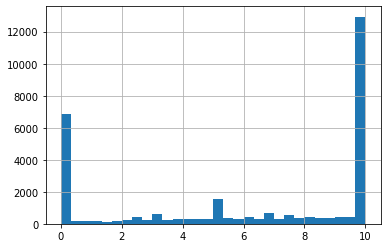

In [41]:
# Visualize distribution of scores across all indicators and countries
combined_normalized_csv.loc[:, 'SCALED_OBS_VALUE'].hist(bins = 30)

# save fgure
plt.savefig(validation_and_analysis / 'distribution_all_scores.png')

# Visualize the distirbution of scores of a specific countries
#combined_normalized_csv.loc[combined_normalized_csv.COUNTRY_ISO_3 == 'DEU', 'SCALED_OBS_VALUE'].hist(bins = 30)

#### Country-pair comparison sanity check

We expect the score of some countries to be higher for most indiators than that of other countries. With the following country pairs we tried to have a global coverage with countries from each world region: 

* Germany > Indonesia
* Panama > Peru 
* UK > India 
* Canada > Tanzania
* Sweden > Mexico
* Netherlands > Myanmar

In [42]:
country_pair_list = [
    ['DEU', 'IDN'],
    ['PAN', 'PER'],
    ['GBR', 'IND'],
    ['CAN', 'TZA'],
    ['SWE', 'MEX'],
    ['NLD', 'MMR']
]

for pair in country_pair_list:
    # Subset total dataframe
    df = combined_normalized_csv.loc[
        (combined_normalized_csv['COUNTRY_ISO_3'] == pair[0]) |
        (combined_normalized_csv['COUNTRY_ISO_3'] == pair[1]),
        ['COUNTRY_ISO_3', 'SCALED_OBS_VALUE', 'INDICATOR_CODE', 'INTERNAL_SOURCE_ID']
    ]

    # Check there aren't duplicates
    # TO DO re-write this into an asser statement
    df = df.loc[df.SCALED_OBS_VALUE.notna(), :].drop_duplicates(subset = ['COUNTRY_ISO_3', 'INDICATOR_CODE'])

    # Pivot the table (long to wide format)
    df = df.pivot(index = ['INDICATOR_CODE', 'INTERNAL_SOURCE_ID'], columns = 'COUNTRY_ISO_3', values = 'SCALED_OBS_VALUE')

    # Create new column
    df.loc[
        df[pair[0]] < df[pair[1]],
        'INDICATOR_REQUIRES_DOUBLE_CHECK'
    ] = 'YES'

    # safe dataframe
    df.to_csv(validation_and_analysis / ('country_pair_score_comparison_sanity_check_' + pair[0] + '-' + pair[1] + '.csv'), sep = ";") 

#### Country ranking per issue/ category/ index/ overall score  

We expect certain countries to be in certain segments of the overall ranking. That is, we generally expect the distribution of rankings from best to worst to be as follow for most indicators: 

* Scandinavian countries
* Other European countries (northern) + Canada
* USA + Southern European countries
* Emerging economies (Brasil, Turke, Ethiopia, Asian emerging economies)
* Countries in conflict

The following code calculates the ranking per issue/ category/ index/ overall to examine the assumption

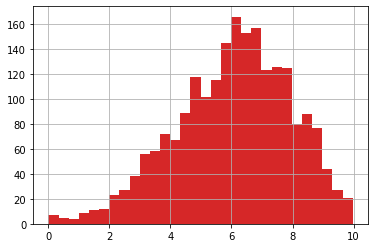

In [49]:
# # # # # # # 
# Overall score
overall_score = combined_normalized_csv.loc[:, ['COUNTRY_ISO_3', 'SCALED_OBS_VALUE', 'COUNTRY_NAME']].groupby(by = ['COUNTRY_ISO_3']).mean()

# Get back country_name (could not be include in group by)
overall_score = overall_score.merge(
    right=country_crba_list[['COUNTRY_ISO_3', 'COUNTRY_NAME']],
    on='COUNTRY_ISO_3',
    how='left'
)

# Rename column 
overall_score = overall_score.rename(columns={'SCALED_OBS_VALUE' : 'OVERALL_SCORE'})

# Save dataframe
overall_score.to_csv(    
    path_or_buf = validation_and_analysis / 'overall_score_country_ranking.csv',
    sep = ";")

# Visualize distribution of overall scores
overall_score.loc[:, 'OVERALL_SCORE'].hist(bins = 30)

# save fgure
plt.savefig(validation_and_analysis / 'distribution_overall_country_scores.png')


###############
# Loop through ranking per issue/ category/ index

dimension_list = [
    'INDICATOR_INDEX',
    'INDICATOR_CATEGORY',
    'INDICATOR_ISSUE'
]

for element in dimension_list:
    # Subset to relevant dimension
    dataframe_score = combined_normalized_csv.loc[:, [element,'COUNTRY_ISO_3', 'SCALED_OBS_VALUE']].groupby(by = [element,'COUNTRY_ISO_3'], as_index= False).mean()

    # Get back country_name (could not be include in group by)
    dataframe_score = dataframe_score.merge(
        right=country_crba_list[['COUNTRY_ISO_3', 'COUNTRY_NAME']],
        on='COUNTRY_ISO_3',
        how='left'
    )

    # Rename column 
    dataframe_score = dataframe_score.rename(columns={'SCALED_OBS_VALUE' : (element + '_SCORE')})

    # Save dataframe
    dataframe_score.to_csv(    
        path_or_buf = validation_and_analysis / (element + '_score_country_ranking.csv'),
        sep = ";")

    # Visualize distribution of overall scores
    dataframe_score.loc[:, (element + '_SCORE')].hist(bins = 30)

    # save fgure
    plt.savefig(validation_and_analysis / ('distribution_' + element + '_country_scores.png'))

### Comparison of 2018 and 2020 scores

* Compare th rank of countries in 2018and 2020


In [44]:
# Creat empty dataframe
crba_2018_scores = pd.DataFrame()

# Crete list to loop through all indeces
index_parameter_list = [#workplace
    [
        'CRWP_Score_Sheet_V31.xlsx',
        'Unnamed: 152',
        'Workplace'
    ], # Marketlace
    [
        'CRMP_Score_Sheet_V23.xlsx',
        'Unnamed: 100',
        'Marketplace' 
    ],
    [
        'CRCE_Score_Sheet_V25.xlsx',
        'Unnamed: 133',
        'Community and Environment'
    ]
]

# Loop through list
for index in index_parameter_list:
    # read file
    df = pd.read_excel(
        cwd / 'data_out'  / 'Nov 2018 - Full global release' / index[0],
        sheet_name = 'Analysis sheet'
    )

    # Discard unnecessary column
    df = df.loc[:, ['Analysis part', index[1]]]

    # Add country_iso_3 code
    df = df.merge(
        right = country_full_list[['COUNTRY_ISO_3', 'COUNTRY_NAME']],
        left_on='Analysis part',
        right_on='COUNTRY_NAME',
        how='inner'
    )

    # Add indicator index column
    df['INDICATOR_INDEX'] = index[2]

    # Rename target column
    df = df.rename(
        columns = {
            index[1] : 'CRBA_2018_INDEX_SCORE'
        }
    )

    # Append to dataframe
    crba_2018_scores = crba_2018_scores.append(
        df
    )

count    579.000000
mean       0.494842
std        1.145480
min       -5.214206
25%       -0.075794
50%        0.550367
75%        1.175788
max        5.447047
Name: SCORE_CHANGE, dtype: float64


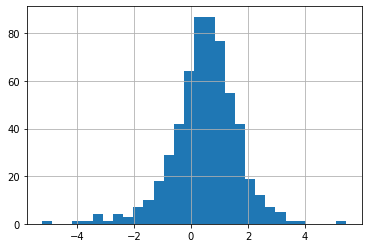

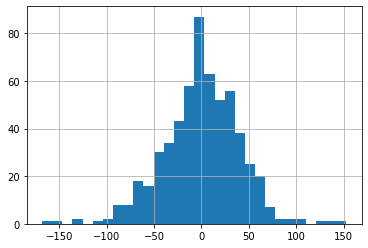

In [60]:
# Merge 2018 and 2019 data
crba_2020_scores = pd.read_csv(
    validation_and_analysis / 'INDICATOR_INDEX_score_country_ranking.csv',
    sep = ';'
)

# Join dataframe
index_scores_2018_2020 = crba_2020_scores.merge(
    right = crba_2018_scores [['INDICATOR_INDEX', 'COUNTRY_ISO_3', 'CRBA_2018_INDEX_SCORE']],
    on = ['INDICATOR_INDEX', 'COUNTRY_ISO_3']
)

# Calculate difference between scores
index_scores_2018_2020['SCORE_CHANGE'] = index_scores_2018_2020['INDICATOR_INDEX_SCORE'] - index_scores_2018_2020['CRBA_2018_INDEX_SCORE']

print(index_scores_2018_2020['SCORE_CHANGE'].astype(float).describe())

# cast as numeric to create rank
index_scores_2018_2020['CRBA_2018_INDEX_SCORE'] = index_scores_2018_2020['CRBA_2018_INDEX_SCORE'].astype(float)

index_scores_2018_2020['INDICATOR_INDEX_SCORE'] = index_scores_2018_2020['INDICATOR_INDEX_SCORE'].astype(float)


# Add rank 2018
index_scores_2018_2020['RANK_2018'] = index_scores_2018_2020.loc[:, ['INDICATOR_INDEX', 'CRBA_2018_INDEX_SCORE']].groupby(['INDICATOR_INDEX'], as_index=True).rank(axis=0, method='dense', ascending=False)

# Add rank 2020
index_scores_2018_2020['RANK_2020'] = index_scores_2018_2020.loc[:, ['INDICATOR_INDEX', 'INDICATOR_INDEX_SCORE']].groupby(['INDICATOR_INDEX'], as_index=True).rank(axis=0, method='dense', ascending=False)

# Calculate change of rank from 2018 to 2020
index_scores_2018_2020['RANK_CHANGE'] = index_scores_2018_2020['RANK_2018'] - index_scores_2018_2020['RANK_2020']

# Save dataframe
index_scores_2018_2020.to_csv(
    validation_and_analysis / 'index_scores_comparison_2018_2020.csv',
    sep=';'
)

# Visualize the distributon of score changes
index_scores_2018_2020.loc[:, 'SCORE_CHANGE'].hist(bins = 30)

# save fgure
plt.savefig(validation_and_analysis / 'index_score_change_distriution')
plt.show()


# Visualize the distributon of rank changes
index_scores_2018_2020.loc[:, 'RANK_CHANGE'].hist(bins = 30)

# save fgure
plt.savefig(validation_and_analysis / 'index_rank_change_distriution')

# DEVELOPMENT AND TRASH AREA

## Validation

* 

In [21]:


list_1 = relevant_observations.loc[relevant_observations['INDICATOR_CODE'] == 'MP_MA_LF_AGLIOA', 'COUNTRY_ISO_3']

list_2 = country_crba_list['COUNTRY_ISO_3']

np.setdiff1d(list_2,list_1)

array(['LIE', 'PSE', 'XKX'], dtype=object)

In [ ]:
# Read combined dataframe
index_score_csv = pd.read_csv(
    cwd / 'data_out' / 'index_scores.csv',
    sep = ";"
)

index_score_csv = index_score_csv.merge(
    right=country_crba_list,
    how='left',
    on='COUNTRY_ISO_3'
)

index_score_csv.to_csv(
    path_or_buf = cwd / 'data_out' / 'index_scores.csv',
    sep = ";"
)

In [ ]:
"""

# # # # # # # 
# Index score
index_score = combined_normalized_csv.loc[:, ['INDICATOR_INDEX','COUNTRY_ISO_3', 'SCALED_OBS_VALUE']].groupby(by = ['INDICATOR_INDEX','COUNTRY_ISO_3']).mean()

# Rename column 
index_score = index_score.rename(columns={'SCALED_OBS_VALUE' : 'ATTR_INDEX_SCORE'})

# Temp: Save dataframe
index_score.to_csv(    
    path_or_buf = cwd / 'data_out' / 'index_scores.csv',
    sep = ";")

# Join back to add column to original dataframe
combined_normalized_csv = combined_normalized_csv.merge(
    right=index_score,
    on=['INDICATOR_INDEX','COUNTRY_ISO_3']
)



# # # # # # # 
# Index score
index_score = combined_normalized_csv.loc[:, ['INDICATOR_INDEX','COUNTRY_ISO_3', 'SCALED_OBS_VALUE']].groupby(by = ['INDICATOR_INDEX','COUNTRY_ISO_3']).mean()

# Rename column 
index_score = index_score.rename(columns={'SCALED_OBS_VALUE' : 'ATTR_INDEX_SCORE'})

# Temp: Save dataframe
index_score.to_csv(    
    path_or_buf = cwd / 'data_out' / 'index_scores.csv',
    sep = ";")

# Join back to add column to original dataframe
combined_normalized_csv = combined_normalized_csv.merge(
    right=index_score,
    on=['INDICATOR_INDEX','COUNTRY_ISO_3']
)

# # # # # # # 
# Issue score
issue_score = combined_normalized_csv.loc[:, ['INDICATOR_ISSUE','COUNTRY_ISO_3', 'SCALED_OBS_VALUE']].groupby(by = ['INDICATOR_ISSUE','COUNTRY_ISO_3']).mean()

# Rename column
issue_score = issue_score.rename(columns={'SCALED_OBS_VALUE' : 'ATTR_ISSUE_SCORE'})

# Temp: Save dataframe
issue_score.to_csv(    
    path_or_buf = validation_and_analysis / 'issue_scores.csv',
    sep = ";")

# Join back to add column to original dataframe
combined_normalized_csv = combined_normalized_csv.merge(
    right=issue_score,
    on=['INDICATOR_ISSUE','COUNTRY_ISO_3']
)

# # # # # # # # 
# Caregory score
category_score = combined_normalized_csv.loc[:, ['INDICATOR_CATEGORY','COUNTRY_ISO_3', 'SCALED_OBS_VALUE']].groupby(by = ['INDICATOR_CATEGORY','COUNTRY_ISO_3']).mean()

# Rename column
category_score = category_score.rename(columns={'SCALED_OBS_VALUE' : 'ATTR_CATEGORY_SCORE'})

# Temp: Save dataframe
category_score.to_csv(    
    path_or_buf = validation_and_analysis / 'category_scores.csv',
    sep = ";")

# Join back to add column to original dataframe
combined_normalized_csv = combined_normalized_csv.merge(
    right=category_score,
    on=['INDICATOR_CATEGORY','COUNTRY_ISO_3']
)

# Save combined dataframe 
combined_normalized_csv.to_csv(
    path_or_buf = validation_and_analysis / 'combined_normalized.csv',
    sep = ";"
)"""

### Tracing down bugs in TEMP_DEBUG file

In [ ]:
######## TEMP DEVELOPMENT to debug all the anomalies I found
print(len(combined_normalized_csv.loc[(combined_normalized_csv.OBS_STATUS == 'O') | (combined_normalized_csv.SCALED_OBS_VALUE.notna()), ].INDICATOR_CODE.unique()))

print(len(combined_normalized_csv.INDICATOR_CODE.unique()))

dataframe = pd.read_csv(
        data_sources_normalized / "S-125_normalized.csv",
        sep = ';'
    )

# dataframe

len(dataframe["COUNTRY_ISO_3"].unique())


WP_DW_OC_GEPAGA_unique = relevant_observations.loc[relevant_observations['INDICATOR_CODE'] == 'WP_DW_OC_GEPAGA', 'COUNTRY_ISO_3'].unique()

WP_DW_OC_AVEEAR_unique = relevant_observations.loc[relevant_observations['INDICATOR_CODE'] == 'WP_DW_OC_AVEEAR', 'COUNTRY_ISO_3'].unique()

MP_OL_OC_FREBUL_unique = relevant_observations.loc[relevant_observations['INDICATOR_CODE'] == 'MP_OL_OC_FREBUL', 'COUNTRY_ISO_3'].unique()


np.setdiff1d(country_crba_list['COUNTRY_ISO_3'], MP_OL_OC_FREBUL_unique)

### UNCTAD sources

In [ ]:
s_121 = pd.read_excel(    
    data_in
    / "data_raw_manually_extracted"
    / "S-121_CC.xlsx")

s_121['RAW_OBS_VALUE'] = s_121['Title of Legislation/Draft Legislation'].apply(lambda x: '2' if re.search('Draft', x) else '3')

# re.search("Draft", s_121.iloc[242, 1])

s_121[s_121['RAW_OBS_VALUE'] == '2']


# # # # # # 

s_122 = pd.read_excel(    
    data_in
    / "data_raw_manually_extracted"
    / "S-122_DP.xlsx")




s_122['RAW_OBS_VALUE'] = s_122['Title of Legislation/Draft Legislation'].apply(lambda x: '2' if re.search('Draft', x) else '3')

# re.search("Draft", s_121.iloc[242, 1])

s_122[s_122['RAW_OBS_VALUE'] == '2']

# s_122

## Extract selenium sources --> This code is stable as of 06.11.20, TO DO is to put this into a loop (which must be done in container, so I can only do it once James has looked at the issue with Chrome driver)

In [ ]:
dataframe_cleansed.loc[dataframe_cleansed.duplicated(subset = ['COUNTRY_ISO_3'])]

In [5]:
# ILO Normlex sources
ilo_normlex_sources = crba_data_dictionary_source[crba_data_dictionary_source.SOURCE_BODY == 'ILO NORMLEX'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Sources S-168, S-169 and S-170 require a different ETL (i.e. the same ETL as UN Treaties) --> Exclude them from this loop 
# ilo_normlex_sources = ilo_normlex_sources[
# (ilo_normlex_sources["SOURCE_ID"] != 'S-1')]# & 
#(manually_extracted_sources["SOURCE_ID"] != 'S-169') &
#(manually_extracted_sources["SOURCE_ID"] != 'S-170') #&
#(manually_extracted_sources["SOURCE_ID"] == 'S-21')] 

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Define parameters required for Selenium to work (can't use Posix path with selenium)
# Specify location of chromedriver
cwd = os.getcwd()
driver_location = cwd + '\\chromedriver.exe'

# Add option to make it headless (so that it doesn't open an actual chrome window)
options = Options()
options.headless = True
driver = webdriver.Chrome(driver_location, chrome_options=options)
    
# Loop to extract data from API sources
for index, row in ilo_normlex_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))

    # request
    print(row["ADDRESS"])
    response = driver.get(row["ADDRESS"])

    # Soupify the actual html content from response
    soup = bs.BeautifulSoup(driver.page_source)

    # Extract the target table as attribute
    target_table = str(
        soup.find_all("table", {"cellspacing": "0", "class": "horizontalLine"})
    )

    # Create dataframe with the data
    raw_data = pd.read_html(io=target_table, header=0)[
        0
    ]# return is a list of DFs, specify [0] to get actual DF

    # Save raw data (as actual raw, rather than staged raw data)
    raw_data.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )

    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=raw_data,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().decompose_country_footnote_ilo_normlex(
        dataframe = dataframe,
        country_name_list = country_full_list["COUNTRY_NAME"]
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["SOURCE_ID"], # TO DO: exchange this with row["INDICATOR_CODE"] in selenium  
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body='ILO NORMLEX'
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Create log info
    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        log_info=True
        )

    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

Dataframe cleansed was not defined yet. Now defining it.
Dataframe normalized was not defined yet. Now defining it.


C:\Users\Michael\anaconda3\envs\unicef-test\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: use options instead of chrome_options



 - - - - - 
 Extracting source S-1 

https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312283:NO

 - - - - - 
 Cleansing source S-1 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 - - - - - 
 Extracting source S-2 

https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO::P11300_INSTRUMENT_ID:312327

 - - - - - 
 Cleansing source S-2 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countr


 - - - - - 
 Cleansing source S-32 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 - - - - - 
 Extracting source S-33 

https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312232:NO

 - - - - - 
 Cleansing source S-33 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is 

### Debug the extract country name function

In [ ]:
def extract_country_name(cell, country_name_list_temp=country_full_list['COUNTRY_NAME']):
    # Determine which country in the full country list is contained in string
    subset_list = [x in cell for x in country_name_list_temp]

    # Sometimes several country names match, but we need exactly one
    if sum(subset_list) == 0:
        print("No country name match")
    elif sum(subset_list) == 1:
        # Retrieve the actual country name
        country_name = country_name_list_temp[subset_list].item()
    else:
        # Some country naes contain other country names (Nigeria contains Niger)
        # Extract the longest string
        country_name = max(country_name_list_temp[subset_list], key = len)
    
    # Return result
    return country_name
        
        
extract_country_name('South Korea')

### Selenium Temp

In [ ]:
# Specify location of chromedriver
cwd = os.getcwd()
driver_location = cwd + '\\chromedriver.exe'

# Add option to make it headless (so that it doesn't open an actual chrome window)
options = Options()
options.headless = True
driver = webdriver.Chrome(driver_location, chrome_options=options)

response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312240:NO")

# Retrieve html from response
html = driver.page_source

# Soupify
soup = bs.BeautifulSoup(html)

# Extract the target table as attribute
target_table = str(
    soup.find_all("table", {"cellspacing": "0", "class": "horizontalLine"})
)

# Create dataframe with the data
raw_data = pd.read_html(io=target_table, header=0)[
    0
]  # return is a list of DFs, specify [0] to get actual DF

raw_data

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Specify location of chromedriver
cwd = os.getcwd()
driver_location = cwd + '\\chromedriver.exe'

# Add option to make it headless (so that it doesn't open an actual chrome window)
options = Options()
options.headless = True
driver = webdriver.Chrome(driver_location, chrome_options=options)

# Get HTTP response
# response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312256:NO")
# response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO::P11300_INSTRUMENT_ID:312283")
response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312328:NO")
# response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312240:NO")

# Get response
# response = driver.get(html_url)

# Retrieve the actual html
# html = driver.page_source

# Soupify
soup = bs.BeautifulSoup(driver.page_source)

# Extract the target table as attribute
target_table = str(
    soup.find_all("table", {"cellspacing": "0", "class": "horizontalLine"})
)

# Create dataframe with the data
raw_data = pd.read_html(io=target_table, header=0)[
    0
]  # return is a list of DFs, specify [0] to get actual DF

# Cleansing
dataframe = cleanse.Cleanser().rename_and_discard_columns(
    raw_data=raw_data,
    mapping_dictionary=mapping_dict,
    final_sdmx_col_list=sdmx_df_columns_all
)

dataframe = cleanse.Cleanser().decompose_country_footnote_ilo_normlex(
    dataframe = dataframe,
    country_name_list = country_full_list.COUNTRY_NAME
)

dataframe = cleanse.Cleanser().add_and_discard_countries(
    grouped_data=dataframe,
    crba_country_list=country_crba_list,
    country_list_full = country_full_list
)

dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
    dataframe = dataframe,
    treaty_source_body='ILO NORMLEX'
)

# Normalizing section
dataframe_normalized = scaler.normalizer(
    cleansed_data = dataframe_cleansed,
    sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
    # dim_cols=sdmx_df_columns_dims,
    variable_type = row["VALUE_LABELS"],
    is_inverted = row["INVERT_NORMALIZATION"],
    whisker_factor=1.5,
    raw_data_col="RAW_OBS_VALUE",
    scaled_data_col_name="SCALED_OBS_VALUE",
    maximum_score=10,
    )
    
dataframe_normalized

In [ ]:
dataframe_normalized.RAW_OBS_VALUE.unique()

In [ ]:
from selenium.webdriver.chrome.options import Options

In [ ]:
re.sub(dataframe["ATTR_FOOTNOTE_OF_SOURCE"][5]
       
# Speifically for ILO NORMLEX - extract country name if additonal info is given
#dataframe["ATTR_FOOTNOTE_OF_SOURCE"] = dataframe["COUNTRY_NAME"]
#dataframe["COUNTRY_NAME"] = dataframe["COUNTRY_NAME"].apply(extract_country_name)
#dataframe["ATTR_FOOTNOTE_OF_SOURCE"] = dataframe.apply(lambda x: re.sub(x['COUNTRY_NAME'], "", x["ATTR_FOOTNOTE_OF_SOURCE"]), 1)


In [ ]:
import requests
import bs4 as bs
import pandas as pd
import selenium
import os
from pathlib import Path
from selenium import webdriver

# cwd = Path('.')
cwd = os.getcwd()

# Current working directory
driver_location = cwd + '\\geckodriver.exe'

print(driver_location)

# Open the targete html. Must be done with selenium, because it doesnt work with normal URL request
#driver = webdriver.Firefox(executable_path="D:/Documents/2020/28_UNICEF/10_working_repo/data-etl/geckodriver.exe")
driver = webdriver.Firefox(executable_path=driver_location)

# Get HTTP response
response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312256:NO")
